This is a slightly involved classification notebook - using superpixels to generate features. The results look good in that we reduce commission errors. The segmentation might be 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from pprint import pprint
from tqdm import tqdm

from dem_stitcher.rio_window import read_raster_from_window
from dem_stitcher.rio_tools import reproject_arr_to_match_profile
import numpy as np
import geopandas as gpd
from osgeo import gdal
import pandas as pd
import rasterio
from rasterio.crs import CRS
from rasterio import plot
from rasterio.warp import transform_bounds
from rasterio.windows import Window
from rscube.nd_tools import (get_array_from_features, 
                             get_features_from_array, 
                             get_superpixel_area_as_features, 
                             get_superpixel_means_as_features,
                             get_superpixel_stds_as_features, 
                             scale_img)
from rscube.rio_tools import (get_geopandas_features_from_array, 
                              rasterize_shapes_to_array, 
                              get_indices_from_extent, get_cropped_profile)
from scipy import ndimage
from shapely.geometry import box

from skimage.color import label2rgb
from skimage.segmentation import felzenszwalb
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

## Workflow
1. **Prepare Planet Dataset**
    1. Download Planet data
    1. Identify intersecting chips (will there ever be more than 1?)
    1. Subset planet data to intersecting chip extents
    1. Remove pixels from every Planet data band corresponding to no-data pixels in the coastal_blue band
    1. Normalize the data
    1. Clip the top and bottom 2% of pixel values (no-data value == 0)
    1. Update image profile
1. **Perform Segmentation**
    1. Create segmentations with min sizes of 10, 25, and 50 pixels
    1. Save segments to vector files
1. **Generate Features**
    1. Flatten each band of rgnir image
    1. Identify features for each segmentation based on
        1. Superpixel means
        1. Superpixel standard deviations
    1. Generate arrays of labeled features
        1. features from superpixel means
        1. features from superpixel standard deviations
    1. Generate Geotiffs of labeled features
    1. Create an array containing flattened features (red, green, nir), and all super pixel bands
1. **Generate Training Data**
    1. Create  a water mask, where there is >= OCC_MIN% chance of water occurance
    1. Create a land mask, where pixels are > DIST_TO_EXTENT from a non-zero water occurance
    1. Create an array of training data where 
        1. 0=no-data
        1. 1=water
        1. 2=land
    1. Reproject training data to EPSG of Planet data
    1. Write training data to geotiff
1. **Subset Training Data**
    1. Create a mask of land or water occurrences from training data
    7. Remove no-data pixels from all_features and labels arrays
    8. Randomly subset training data in such a way that it has equal water and land
    9. Split feature and training data arrays into random train and test subsets
1. **Build a Random Forest**
    10. Generate a random forest classifier
    11. Build a random forest from training data and labels
1. **Predict Test Data Classifications**
    12. Predict classifications on test data
    13. Create Pandas Series of class predictions and "ground truth" for each pixel to gauge accuracy
1. **Predict Feature Data Classifications**
    14. Remove feature pixels corresponding to chip no-data pixels
    15. Predict classifications (water or no-water) on feature data
    16. Write predicted classification to geotiff

    


Currently, we don't have a way to link chips and planet IDs we are using so this is manual.

In [3]:
PLANET_ID = '20211003_161639_91_241d_3B_AnalyticMS_SR_8b'

In [4]:
planet_image_path = Path(f'local_chips/{PLANET_ID}.tif')
planet_image_path.exists()

False

# **1.Prepare Planet Imagery**

We crop imagery based on chip extents

### **Read in chips**
- Note that geometries are in Long/Lat

In [5]:
df = gpd.read_file('chips.geojson')
df.head()

CENTERX  CENTERY  STRATA SAMPLE_ID        date  LS_Validat  random_id  \
0 -159.648125    69.21       3      3_38  2011-07-17           1         99   
1 -112.983750    67.05       4      4_27  2012-07-23           1        114   
2   17.698500    65.97       4      4_43  2010-07-24           1         20   
3   59.675000    65.79       3       3_1  2011-07-13           1        112   
4  -96.604375    62.73       4      4_34  2012-08-27           1        115   

                                            geometry  
0  POLYGON ((-159.89875 69.30000, -159.65900 69.3...  
1  POLYGON ((-113.21200 67.14000, -113.09850 67.1...  
2  POLYGON ((17.61000 66.06000, 17.91700 66.06000...  
3  POLYGON ((59.86900 65.88000, 59.89200 65.88000...  
4  POLYGON ((-96.79875 62.82000, -96.57700 62.820...

### **Open Planet imagery and collect needed metadata**

- Note that CRS is UTM

In [7]:
with rasterio.open(planet_image_path) as ds:
    image_crs = ds.crs
    image_box = box(*ds.bounds)
    image_bounds = list(ds.bounds)
    image_profile = ds.profile
    image_shape = image_profile['height'], image_profile['width']

print(f'Planet Imagery Shape: {image_shape}')
print(f'Planet Imagery CRS: {image_crs}')
print(f'Planet Image Profile: {image_profile}')

Planet Imagery Shape: (10003, 13622)
Planet Imagery CRS: EPSG:32615
Planet Image Profile: {'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 13622, 'height': 10003, 'count': 8, 'crs': CRS.from_epsg(32615), 'transform': Affine(3.0, 0.0, 211509.0,
       0.0, -3.0, 3673038.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'pixel'}


### **Identify chips that intersect Planet imagery**

- Convert Chip geometry (Long/Lat) to Planet imagery's UTM
- Create Dataframe of all chips intersecting Planet imagery

In [8]:
df_utm = df.to_crs(image_crs)
intersects = df_utm.geometry.intersects(image_box) # create intersection mask
df_chip = df_utm[intersects].reset_index(drop=True) # create new Dataframe containing intersecting chips
df_chip.head()

CENTERX  CENTERY  STRATA SAMPLE_ID        date  LS_Validat  random_id  \
0 -95.866875    33.03       3      3_40  2011-07-10           1         42   

                                            geometry  
0  POLYGON ((222530.752 3668526.777, 241571.451 3...

### **Create a profile of Planet imagery, subset to chip extents**
- Calculate the subset extents in y,x
- Create slices from extents
- Create subset image profile

In [9]:
(start_y, start_x), (stop_y, stop_x) = get_indices_from_extent(image_profile['transform'],
                                                               list(df_chip.total_bounds),
                                                               shape=image_shape)
window = Window.from_slices((start_y, stop_y), (start_x, stop_x))
sx, sy = np.s_[start_x: stop_x], np.s_[start_y: stop_y]
profile_cropped = get_cropped_profile(image_profile, sx, sy)
print(f'Cropped Planet Image Profile: {profile_cropped}')

Cropped Planet Image Profile: {'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 6840, 'height': 6838, 'count': 8, 'crs': CRS.from_epsg(32615), 'transform': Affine(3.0, 0.0, 221964.0,
       0.0, -3.0, 3668529.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'pixel'}


### **Collect the index of the intersecting chip**

We are going to label things based on the chip index.

***TODO: Do we need to account for >1 possible chip intersection?***

In [10]:
index = df_chip.random_id[0]
index

42

### **Take a look at Planet imagery bands**

In [11]:
with rasterio.open(planet_image_path) as ds:
    t = ds.tags()
    d = ds.descriptions
list(enumerate(d))

[(0, 'coastal_blue'),
 (1, 'blue'),
 (2, 'green_i'),
 (3, 'green'),
 (4, 'yellow'),
 (5, 'red'),
 (6, 'rededge'),
 (7, 'nir')]

### **Plot the Red, Green, and Near-Infrared bands of the unsubset Planet Imagery**

In [12]:
def get_raster_threshold(raster, low=2, high=98):
    return [np.nanpercentile(raster, low),
            np.nanpercentile(raster, high)]

Planet Image shape: (6838, 6840, 8)


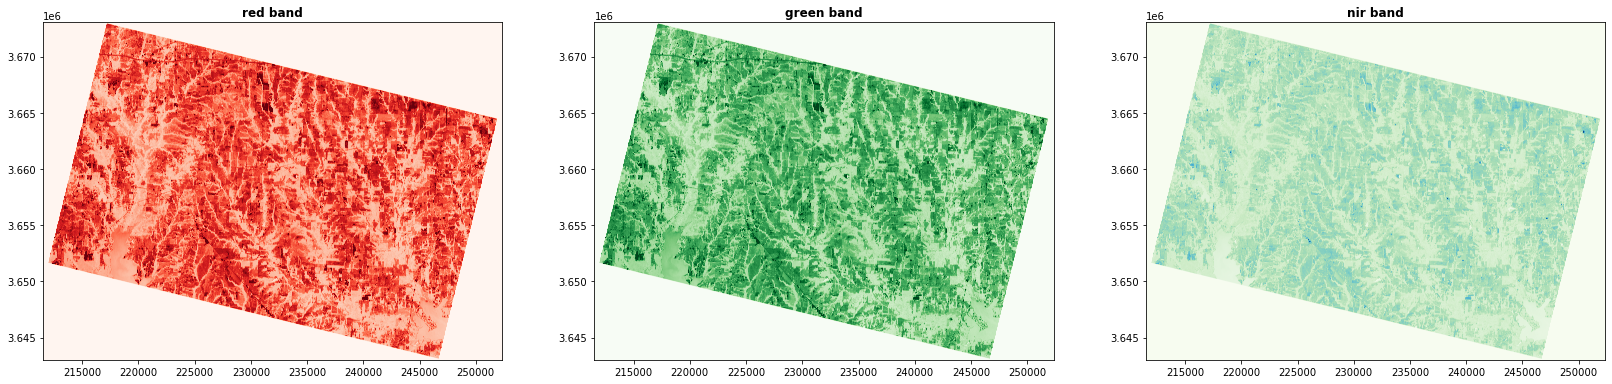

In [13]:
from rasterio.plot import show

with rasterio.open(planet_image_path) as ds:
    image_c = ds.read(window=window)
    image_c = image_c.transpose([1, 2, 0]).astype(np.float32)
    
    fig, (ax_r, ax_g, ax_nir) = plt.subplots(1, 3, figsize=(28,7))
    thresh = get_raster_threshold(image_c[..., 7])
    show((ds, 7), ax=ax_nir, cmap='GnBu', title='nir band', vmin=thresh[0], vmax=thresh[1])
    thresh = get_raster_threshold(image_c[..., 5])
    show((ds, 5), ax=ax_r, cmap='Reds', title='red band', vmin=thresh[0], vmax=thresh[1])
    thresh = get_raster_threshold(image_c[..., 3])
    show((ds, 3), ax=ax_g, cmap='Greens', title='green band', vmin=thresh[0], vmax=thresh[1])
print(f'Planet Image shape: {image_c.shape}')

### **Remove Coastal Blue no-data pixels from all Planet Imagery bands**
- Create a mask of Coastal Blue no-data pixels from Planet imagery
- Use Coastal Blue mask to set corresponding pixels in all bands to np.nan

In [14]:
mask = (image_c[..., 0] == image_profile['nodata'])
image_c[mask, :] = np.nan

### **Subset Planet imagery to Red, Green, NIR bands and normalize data**

RGNir shape: (6838, 6840, 3)


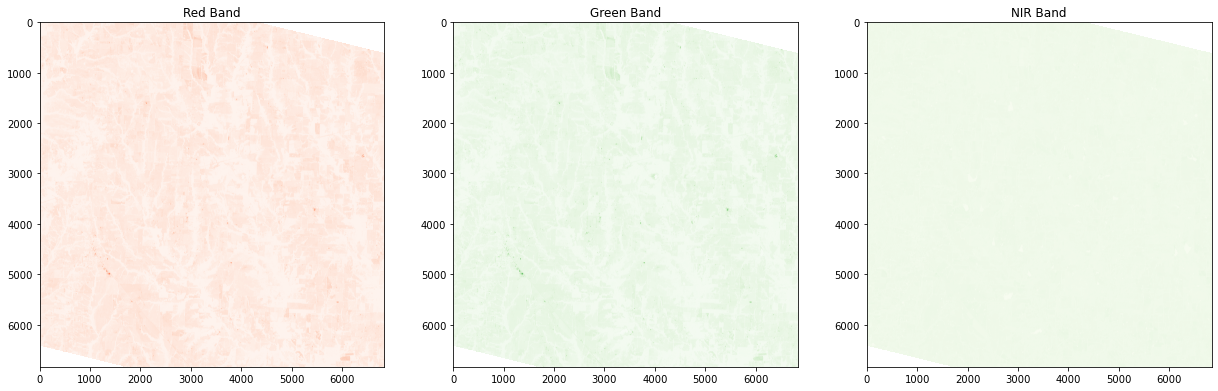

In [22]:
rgnir = scale_img(image_c[..., [7, 5, 3]]) 

fig, (ax_r, ax_g, ax_nir) = plt.subplots(1, 3, figsize=(21, 7))
thresh = get_raster_threshold(rgnir[..., 0])
ax_nir.imshow(rgnir[..., 0], cmap="GnBu")
ax_nir.set_title("NIR Band")

thresh = get_raster_threshold(rgnir[..., 1])
ax_r.imshow(rgnir[..., 1], cmap="Reds")
ax_r.set_title("Red Band")

thresh = get_raster_threshold(rgnir[..., 2])
ax_g.imshow(rgnir[..., 2], cmap="Greens")
_ = ax_g.set_title("Green Band")

print(f'RGNir shape: {rgnir.shape}')

### **Remove outliers (highest and lowest 2% pixel values) from all 3 bands**

In [23]:
image = image_c[..., [7, 5, 3]]

image_view = image.copy()
for k in tqdm(range(3)):
    m0 = np.nanpercentile(image[~mask, k], 2)
    m1 = np.nanpercentile(image[~mask, k], 98)
    image_view[~mask, k] = np.clip(image[~mask, k], m0, m1)

100%|██████████| 3/3 [00:11<00:00,  3.95s/it]


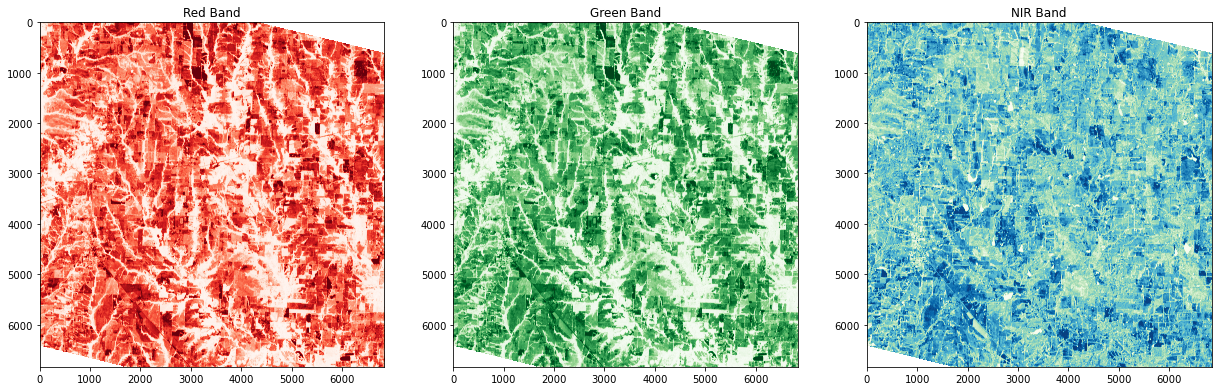

In [24]:
rgnir = scale_img(image_view)
# plt.imshow(rgnir)


fig, (ax_r, ax_g, ax_nir) = plt.subplots(1, 3, figsize=(21, 7))
ax_nir.imshow(rgnir[..., 0], cmap="GnBu")
ax_nir.set_title("NIR Band")

thresh = get_raster_threshold(rgnir[..., 1])
ax_r.imshow(rgnir[..., 1], cmap="Reds")
ax_r.set_title("Red Band")

thresh = get_raster_threshold(rgnir[..., 2])
ax_g.imshow(rgnir[..., 2], cmap="Greens")
_ = ax_g.set_title("Green Band")

### **Create a profile for Planet imagery subset to 3 bands (Red, Green, NIR) and chip extents**  

In [25]:
p_cropped = profile_cropped.copy()
p_cropped['count'] = 3
p_cropped['dtype'] = 'float32'
p_cropped['nodata'] = np.nan
with rasterio.open(f'cropped_to_chip_{index}.tif', 'w', **p_cropped) as ds:
    ds.write(rgnir.transpose([2, 0, 1]))

You could use the above to figure out some training data. We label it `training_data_{index}`, according to the chip ID.

# **2. Segmentation**

Going to use multiscale superpixels - see [this paper](https://www.mdpi.com/2072-4292/12/12/2048) and the references. I learned about them [here](https://link.springer.com/chapter/10.1007/978-94-017-7239-6_8).

Best discussion of felzenswalb algorithm (and parameters below) is by a fellow JPL team: https://ieeexplore.ieee.org/document/5593215

In [26]:
def get_segmentation(image, min_size):
    mask = np.isnan(image[..., 0])
    image_seg = image.copy()
    # So that np.nans don't give us problems
    image_seg[mask, :] = -10_000
    segments_fz = felzenszwalb(image_seg,
                               # may want to play with this
                               scale=5, 
                               # normally gaussian filter is applied - can experiment
                               sigma=0.,
                               # minimum size of segments
                               min_size=min_size
                              )
    return segments_fz

## **Create 3 sets of segmentations using min sizes of 10, 25, and 50**

We are going to use the cropped, 3-band RGNIR image with coastal_blue no-data pixels clipped.

In [27]:
get_segmentation_partial = lambda min_size: get_segmentation(rgnir, min_size)
segmentations = list(map(get_segmentation_partial, tqdm([10, 25, 50])))

100%|██████████| 3/3 [06:52<00:00, 137.50s/it]


**Plot segments with min size of 10**

**Plot segments in all 3 scales (min segment sizes of 10, 25, and 50 pixels)**

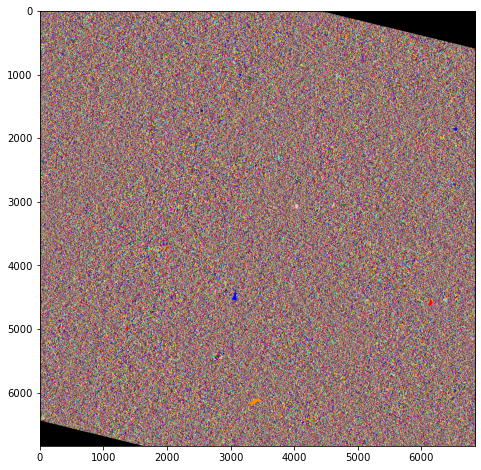

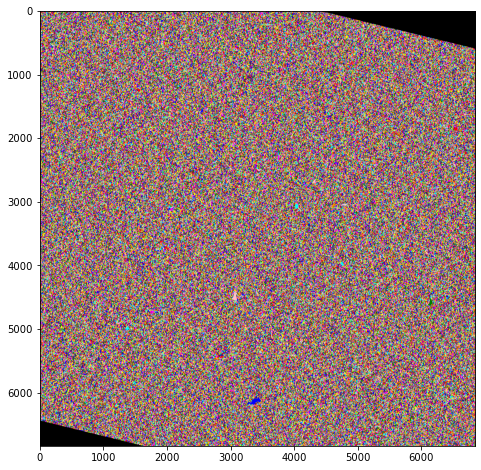

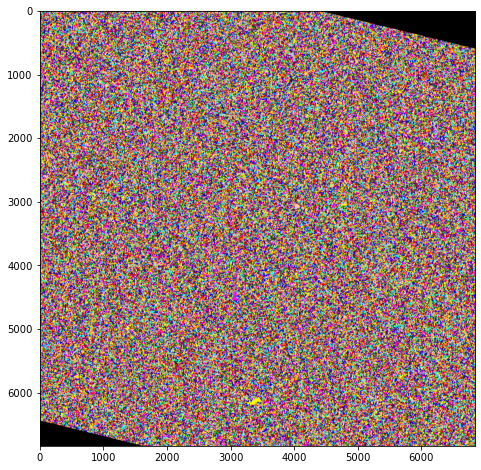

In [28]:
%matplotlib inline

for seg in segmentations:
    seg[mask] = 0
    superpixel_labels_viz = label2rgb(seg, bg_label=0)
    fig, ax = plt.subplots(figsize=(8, 8))                              
    ax.imshow(superpixel_labels_viz)

### **Save segments to vector file**

It takes some time and the segments can be approximately ~1 GB.

In [29]:
segments_fz = segmentations[1]

In [30]:
%%time

features = get_geopandas_features_from_array(segments_fz.astype(np.int32), 
                                             p_cropped['transform'], 
                                             label_name='label')

CPU times: user 49.8 s, sys: 1.34 s, total: 51.2 s
Wall time: 51 s


In [31]:
%%time

df_segments = gpd.GeoDataFrame.from_features(features)
df_segments.head()

CPU times: user 25.5 s, sys: 358 ms, total: 25.9 s
Wall time: 25.8 s


geometry  label
0  POLYGON ((222321.000 3668529.000, 222321.000 3...    9.0
1  POLYGON ((222339.000 3668529.000, 222339.000 3...   12.0
2  POLYGON ((222582.000 3668529.000, 222582.000 3...   24.0
3  POLYGON ((223518.000 3668529.000, 223518.000 3...   61.0
4  POLYGON ((223599.000 3668529.000, 223599.000 3...   64.0

In [32]:
%%time

df_segments.crs = p_cropped['crs']
df_segments.to_file('segments.geojson', driver='GeoJSON')

CPU times: user 5min 29s, sys: 2.03 s, total: 5min 31s
Wall time: 5min 31s


# **3. Generate Features**

In [33]:
rgnir.shape

(6838, 6840, 3)

### **Flatten each band of rgnir data**

In [34]:
pixel_features = rgnir.reshape((-1, rgnir.shape[-1]))
pixel_features.shape

(46771920, 3)

## **Identify features for each segmentation based on superpixel means**

In [35]:
multi_superpixel_features_mean = [get_superpixel_means_as_features(seg, rgnir) for seg in tqdm(segmentations)]
multi_superpixel_features_mean[0].shape

100%|██████████| 3/3 [00:25<00:00,  8.44s/it]


(1371809, 3)

## **Identify features for each segmentation based on superpixel standard deviations**

In [36]:
multi_superpixel_features_std = [get_superpixel_stds_as_features(seg, rgnir) for seg in tqdm(segmentations)]
multi_superpixel_features_std[0].shape

  0%|          | 0/3 [00:00<?, ?it/s]/home/jovyan/.local/envs/dswx_calval/lib/python3.10/site-packages/scipy/ndimage/_measurements.py:523: RuntimeWarning: invalid value encountered in divide
  means = sums / counts
100%|██████████| 3/3 [00:29<00:00,  9.83s/it]


(1371809, 3)

## **Generate arrays of labeled features**

- from multi_superpixel_features_mean
- from multi_superpixel_features_std

In [37]:
multi_superpixel_means = [get_array_from_features(seg, feature) 
                          for (seg, feature) in zip(tqdm(segmentations), multi_superpixel_features_mean)]

multi_superpixel_stds = [get_array_from_features(seg, feature) 
                          for (seg, feature) in zip(tqdm(segmentations), multi_superpixel_features_std)]

100%|██████████| 3/3 [00:54<00:00, 18.15s/it]


## **Generate Geotiffs of features**

In [38]:
scale_ind = 0
p_cropped['count'] = 3

supers = {f'superpixel_means_{scale_ind}_{index}.tif': multi_superpixel_means, 
            f'superpixel_stds_{scale_ind}_{index}.tif': multi_superpixel_stds}

for img in supers:
    with rasterio.open(img, 'w', **p_cropped) as ds:
        ds.write(supers[img][scale_ind].transpose([2, 0, 1]))

## **Flatten each superpixel band (I think this is accurate but confirm with Charlie)**

In [39]:
superpixel_means_pixel_f = [superpixel_means.reshape((-1, rgnir.shape[-1])) 
                            for superpixel_means in multi_superpixel_means]

superpixel_stds_pixel_f = [superpixel_stds.reshape((-1, rgnir.shape[-1])) 
                            for superpixel_stds in multi_superpixel_stds]

## **Build an array containing all features and superpixel bands**

In [40]:
all_features = np.hstack(([pixel_features]  
                          + superpixel_means_pixel_f 
                          + superpixel_stds_pixel_f
                         ))
all_features.shape

(46771920, 21)

# **4. Generate Training Data**

Using Peckel Occurance data to generate training data

https://global-surface-water.appspot.com/download

In [41]:
def build_peckel_vrt(extent: list, 
                     out_path: Path):
    df_peckel_data = gpd.read_file('peckel_tiles.geojson')
    bbox = box(*extent)
    ind_inter = df_peckel_data.geometry.intersects(bbox)
    df_subset = df_peckel_data[ind_inter].reset_index(drop=True)
    gdal.BuildVRT(str(out_path), df_subset.source_url.tolist())
    return out_path

def get_peckel_raster(extent:list) -> tuple:
    tmp_vrt = Path('peckel_data_tmp.vrt')
    build_peckel_vrt(extent, tmp_vrt)
    X, p = read_raster_from_window(tmp_vrt,
                                   extent,
                                   CRS.from_epsg(4326))
    tmp_vrt.unlink()
    p['driver'] = 'GTiff'
    return X, p

## **Create a peckel VRT**
1. convert chip bounds to lat/long
1. create VRT of peckel data, clipped to chip extents

In [42]:
latlong_bounds = df_chip.to_crs(4326).total_bounds
print(latlong_bounds)

X_occ, p_occ = get_peckel_raster(latlong_bounds)

[-95.97375  32.94    -95.76     33.12   ]


In [43]:
X_occ.shape  # Question: why build a VRT for a single raster? Do we expect to eventually use additional bands?

(722, 856)

## **Write clipped peckel data to a geotiff**

In [44]:
with rasterio.open(f'occurence_c{index}.tif', 'w', **p_occ) as ds:
    ds.write(X_occ, 1)

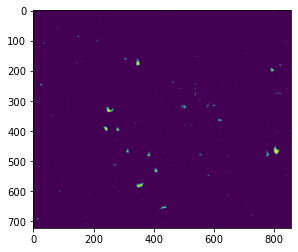

In [45]:
plt.imshow(X_occ)

## **Create masks**

1. Water mask, where there is >= OCC_MIN% chance of water occurance
1. Land mask, where pixels are > DIST_TO_EXTENT from a water occurance

In [46]:
OCC_MIN = 35
DIST_TO_EXTENT = 5

water_ind = (X_occ >= OCC_MIN)
water_extent = (X_occ > 0)

water_extent_arr = (~water_extent).astype(int)
water_dist = ndimage.distance_transform_edt(water_extent_arr)

land_ind = water_dist > DIST_TO_EXTENT

Text(0.5, 1.0, 'Land Mask')

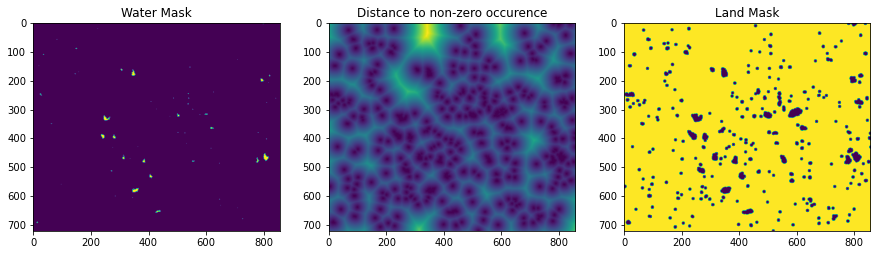

In [47]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))

ax[0].imshow(water_ind)
ax[0].set_title('Water Mask')

ax[1].imshow(water_dist)
ax[1].set_title('Distance to non-zero occurence')

ax[2].imshow(land_ind)
ax[2].set_title('Land Mask')

## **Create a 2D array of training data**
1. 0 = no-data
1. 1 = water
1. 2 = land

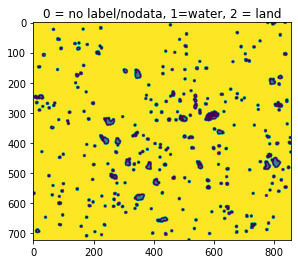

In [48]:
training_data_4326 = np.zeros(X_occ.shape)
training_data_4326[land_ind] = 2
training_data_4326[water_ind] = 1
plt.title('0 = no label/nodata, 1=water, 2 = land')
plt.imshow(training_data_4326)

## **Reproject training data to EPSG of Planet data**

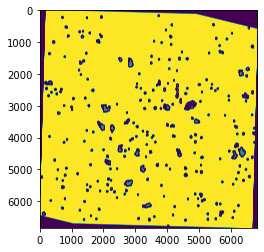

In [49]:
p_temp = p_occ.copy()
p_temp['dtype'] = 'float32'
p_temp['nodata'] = None

training_data_r, p_r = reproject_arr_to_match_profile(training_data_4326, p_temp, p_cropped)
# rounding then casting makes sure the class assigned is closest after reprojection
training_data_r = training_data_r[0, ...]
training_data_r[mask] = 0

plt.imshow(training_data_r)

## **Write training data to GeoTiff**

In [50]:
with rasterio.open('test_train.tif', 'w', **p_r) as ds:
    ds.write(training_data_r, 1)

## **Create a flattened mask of land or water occurances**

- True = land or water
- False = no-data

In [51]:
labels = training_data_r.copy()
labels_f = labels.reshape((-1, 1)).ravel()

f_mask = ~(labels_f == 0).ravel()

## **Remove no-data pixels from all_features and labels arrays**

In [52]:
X_labeled_all = all_features[f_mask]
y_labeled_all = labels_f[f_mask]

## **Randomly subset training data in such a way that it has equal water and land**

There must be a better way to do this - this makes sure training data has equal water and land, the later which is much more over-represented. Think something like this will do: https://imbalanced-learn.org/stable/auto_examples/applications/plot_multi_class_under_sampling.html#sphx-glr-auto-examples-applications-plot-multi-class-under-sampling-py

In [53]:
np.random.seed(0)
water_ind_f = np.where(y_labeled_all == 1)[0]
land_ind_f = np.where(y_labeled_all == 2)[0]
n = water_ind_f.shape[0]
land_ind_f_sample = np.random.choice(land_ind_f, size=n)

indices_for_labeling = np.hstack([water_ind_f, land_ind_f_sample])
indices_for_labeling.shape

y_labeled = y_labeled_all[indices_for_labeling].astype(int)
X_labeled = X_labeled_all[indices_for_labeling, ...]

## **Split feature and training data arrays into random train and test subsets**

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X_labeled, 
                                                    y_labeled, 
                                                    test_size=0.2,
                                                    train_size=0.8,
                                                    random_state=0,
                                                    stratify=y_labeled
                                                   )

## **Generate a random forest classifier**

In [55]:
rf = RandomForestClassifier(n_estimators=500,
                            oob_score=True,
                            random_state=0,
                            n_jobs=8)

## **Build a forest of trees from training data and labels**

In [56]:
%%time

rf.fit(X_train, 
       y_train)

CPU times: user 4min 36s, sys: 129 ms, total: 4min 36s
Wall time: 40 s


RandomForestClassifier(n_estimators=500, n_jobs=8, oob_score=True,
                       random_state=0)

## **Predict classifications (water or no-water) on labeled test data**

In [57]:
%%time

y_pred = rf.predict(X_test)

CPU times: user 1.92 s, sys: 138 ms, total: 2.06 s
Wall time: 328 ms


In [58]:
class_dict = {1: 'water', 
              2: 'not_water'}

## **Create Pandas Series of class predictions and "ground truth" for each pixel**

In [59]:
y_pred_str = pd.Series([class_dict[class_id] for class_id in y_pred], name='Predicted')
y_true_str = pd.Series([class_dict[class_id] for class_id in y_test], name='True')

## **Evaluate the accuracy of our predictions on the labeled data**

Random forests will do pretty well on the labeled data since the labeled data is continugous and the superpixels aggregations will likely be shared across pixels.

In [60]:
df = pd.crosstab(y_true_str, y_pred_str)
df

Predicted  not_water  water
True                       
not_water      16200     10
water              3  16207

## **Remove feature pixels corresponding to chip no-data pixels**

In [61]:
all_mask_f = (mask.reshape((-1,)))

X_all = all_features[~all_mask_f, 
                     ...]

## **Predict classifications (water or no-water) on feature data**

In [62]:
%%time

y_all = rf.predict(X_all)

ValueError: Input X contains NaN.
RandomForestClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
y_arr = np.zeros(mask.shape)

y_arr[~mask] = y_all
y_arr[mask] = 0

In [ ]:
p = profile_cropped.copy()
p['count'] = 1 
p['dtype'] = np.uint8
with rasterio.open(f'class_out_{index}.tif', 'w', **p) as ds:
    ds.write(y_arr.astype(np.uint8), 1)

In [ ]:
plt.imshow(y_arr, interpolation='none')

# Feature Importances

See: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.feature_importances_

In [ ]:
rf.feature_importances_

## *Version Log*

- ***08-08-2022*** *- Alex Lewandowski, ASF*
    - *Added workflow outline*
    - *Added markdown descriptions*
    - *Updated plots*